### POS Tagging

In [1]:
using PyPlot

In [2]:
# https://github.com/JuliaLang/julia/issues/14099
const spaces = filter(isspace, Char(0):Char(0x10FFFF));

In [3]:
function readWordTagData(filePath)
    file = open(filePath);
    vocabSet = Set{AbstractString}();
    tagSet = Set{AbstractString}();
    # read line
    for ln in eachline(file)
        word_tag = split(ln, spaces);
        # remove ""
        word_tag = word_tag[word_tag .!= ""]
        # separate word from tag
        for token in word_tag
            tokenSplit = split(token, "_");
            push!(vocabSet, tokenSplit[1]);
            push!(tagSet, tokenSplit[2]);
        end
    end
    close(file);
    # to handle unknown words
    push!(vocabSet, "UNK_W");
    # to handle unknown tags
    push!(tagSet, "UNK_T");
    #println(vocabSet)
    #println(tagSet)
    vocab = collect(vocabSet);
    tags = collect(tagSet);
    # prepare data array
    data = Tuple{AbstractString , AbstractString }[];
    file = open(filePath);
    # read line
    for ln in eachline(file)
        word_tag = split(ln, spaces);
        # remove ""
        word_tag = word_tag[word_tag .!= ""]
        # separate word from tag
        for token in word_tag
            tokenSplit = split(token, "_");
            push!(data, (tokenSplit[1], tokenSplit[2]));
        end
    end
    close(file);
    #println(length(data))
    return vocab, tags, data;
end

readWordTagData (generic function with 1 method)

In [13]:
# read data
vocabListTrain, tagListTrain, dataTrain = readWordTagData("data/pos/05-train-input.txt");
# = readWordTagData("data/pos/05-train-input.txt");
# = readWordTagData("data/pos/wiki-en-train.norm_pos");
#

# define the network
inputLayerSize = length(vocabListTrain);
hiddenLayerSize = 100;
outputLayerSize = length(tagListTrain);
learningRate = 1e-1;
# initialize weights and biases
Wxh = randn(inputLayerSize, hiddenLayerSize)*0.01; # input to hidden
Whh = randn(hiddenLayerSize, hiddenLayerSize)*0.01; # hidden to hidden
Bh = zeros(1, hiddenLayerSize); # hidden bias
Why = randn(hiddenLayerSize, outputLayerSize)*0.01; # hidden to output
By = zeros(1, outputLayerSize); # output bias

1x4 Array{Float64,2}:
 0.0  0.0  0.0  0.0

- smooth cost
- h previous
- unfolding rnn with sequence length

In [14]:
function forwardRNN(x::Array{Vector{Float64},1}, y::Array{Vector{Float64},1}, 
    h::Array{Float64,2}, p::Array{Vector{Float64},1}, hPrev::Array{Float64,2})
    
    global Wxh, Whh, Why, Bh, By;
    cost = 0;
    # for each time t in x
    # unrolling RNN -> Feedforward NN step
    for time in 1:length(x)
        if time == 1
            h[time] = tanh(x[time]'*Wxh + hPrev*Whh .+ Bh);
        else
            h[time] = tanh(x[time]'*Wxh + h[time-1]*Whh .+ Bh);
        end
        # output layer
        score = h[time]*Why .+ By;
        p_softmax = exp(score) / sum(exp(score));
        p[time] = vec(p_softmax); # output probability distribution (at time t)
        cost += -sum(log(y[time]'*p[time])) # assuming y is a one-hot vector
    end
    return cost;
end

forwardRNN (generic function with 2 methods)

In [15]:
function backwardRNN(x::Array{Vector{Float64},1}, y::Array{Vector{Float64},1}, 
    h::Array{Float64,2}, p::Array{Vector{Float64},1}, hPrev::Array{Float64,2})
    
    global Wxh, Whh, Why, Bh, By;
    
    dWxh = zeros(size(Wxh));
    dWhh = zeros(size(Whh));
    dBh = zeros(size(Bh));
    dWhy = zeros(size(Why));
    dBy = zeros(size(By));
    
    dh = zeros(size(Bh)); # error from the following time step
    dhnext = zeros(size(h[1]));
    for time in length(x):-1:1
        # output layer error
        dy = p[time] - y[time]; #assuming y is a one hot vector
        # output gradient
        dWhy = dWhy + (dy * h[time])';
        dBy = dBy + dy';
        # backpropagate
        dh = (Why*dy)' + dhnext;
        dhRaw = (1 - (h[time].*h[time])) .* dh;
        # hidden layer gradient
        dWxh = dWxh + (x[time] * dhRaw);
        dBh = dBh + dhRaw;
        if time == 1
            dWhh = dWhh + (hPrev' * dhRaw);
        else
            dWhh = dWhh + (h[time-1]' * dhRaw);
        end
        dhnext = dhRaw*Whh;
    end
    # clip to mitigate exploding gradients
    dWxh = clamp(dWxh, -5, 5);
    dWhh = clamp(dWhh, -5, 5);
    dBh = clamp(dBh, -5, 5);
    dWhy = clamp(dWhy, -5, 5);
    dBy = clamp(dBy, -5, 5);
    
    return dWxh, dWhh, dBh, dWhy, dBy;
end

backwardRNN (generic function with 2 methods)

In [16]:
# gradient checking
function gradCheck(inputs::Array{Vector{Float64},1}, targets::Array{Vector{Float64},1},
    h::Array{Float64,2}, p::Array{Vector{Float64},1}, hPrev::Array{Float64,2})
    
    paramNameList = ["Wxh", "Whh", "Bh", "Why", "By"];
    # collect paramters
    global Wxh, Whh, Why, Bh, By;
    paramList = [x for x=(Wxh, Whh, Bh, Why, By)];
    num_checks = 2;
    delta = 1e-5;
    # collect parameter gradients
    cost = forwardRNN(inputs, targets, h, p, hPrev);
    dWxh, dWhh, dBh, dWhy, dBy = backwardRNN(inputs, targets, h, p, hPrev);
    dParamList = [x for x=(dWxh, dWhh, dBh, dWhy, dBy)];
    for (param,dparam,name) in zip(paramList, dParamList, paramNameList)
        # validate the size of the parameter and its gradient
        s0 = size(dparam);
        s1 = size(param);
        if s0 != s1
            println("Error dims dont match: ", s0," and ",s1);
        end
        println(name)
        for i in 1:num_checks
            ri = rand(1:length(param));
            # evaluate cost at [x + delta] and [x - delta]
            old_val = param[ri];
            param[ri] = old_val + delta;
            cg0 = forwardRNN(inputs, targets, h, p, hPrev);
            param[ri] = old_val - delta;
            cg1 = forwardRNN(inputs, targets, h, p, hPrev);
            param[ri] = old_val # reset old value for this parameter
            # fetch both numerical and analytic gradient
            grad_analytic = dparam[ri];
            grad_numerical = (cg0 - cg1) / ( 2 * delta );
            
            rel_error = abs(grad_analytic - grad_numerical) / abs(grad_numerical + grad_analytic);
            println(grad_numerical,", ", grad_analytic, " => ",rel_error);
            # rel_error should be on order of 1e-7 or less
            if rel_error > 1e-5
                error("Gradient check failed.");
            end
            println("Gradient check passed.")
        end
    end
end

gradCheck (generic function with 2 methods)

In [17]:

function train(data::Array{Tuple{AbstractString,AbstractString},1}, vocabList::Array{AbstractString,1} 
    , tagList::Array{AbstractString,1}, numItr::Int64, seqLength::Int64, sampleCostAtItr::Int64)
    
    global Wxh, Whh, Why, Bh, By;
    numIterations =  numItr * length(data);
    costList = []; # store cost per sampled iteration
    ptr = 1;
    p = [zeros(length(tagList)) for i in 1:seqLength];
    h = Array{Float64,2}[zeros(1,hiddenLayerSize) for i in 1:seqLength]; # hidden layers (at time t)
    hPrev = zeros(1, hiddenLayerSize);
   for itr in 1:numIterations
        #println("itr: ", itr)
        # prepare inputs (we're sweeping from left to right in steps seq_length long)
        if ptr+seqLength-1 > length(data) # whenever we are looking at the data from the start
            # reset RNN memory
            hPrev = zeros(1, hiddenLayerSize);
            # go from start of data
            ptr = 1 
        end
        # generate sequence
        seqData = data[ptr:ptr+seqLength-1];
        x = Vector{Float64}[];
        y = Vector{Float64}[];
        for word_tag in seqData
            word = word_tag[1];
            tag = word_tag[2];
            # convert to one-hot vectors
            # words
            wordVec = zeros(length(vocabList));
            findWord = collect(vocabList.==word)
            if length(findWord[findWord.==true]) == 0
                # unknown word: UNK_W
                findWord[length(findWord)] = true;
            end
            wordVec[findWord] = 1;
            # tags
            tagVec = zeros(length(tagList));
            findTag = collect(tagList.==tag)
            if length(findTag[findTag.==true]) == 0
                # unknown tag: UNK_T
                findTag[length(findTag)] = true;
            end
            tagVec[findTag] = 1;
            # push to the sequence
            push!(x , wordVec);
            push!(y , tagVec);
        end
        # gradient check
        gradCheck(x, y, h, p, hPrev);
        
        # move data pointer
        ptr += seqLength;
        println("===")
    end
    return costList;
end

train (generic function with 1 method)

In [18]:
# MAIN
# number of steps to unroll the RNN for
seqLen = 2 
# run through the data n times
numIterOverData = 1;
# sample cost after each n iteration
sampleCostAtEveryItr = 2;
J = train(dataTrain, vocabListTrain, tagListTrain, numIterOverData, seqLen, sampleCostAtEveryItr);

Wxh

LoadError: LoadError: Gradient check failed.
while loading In[18], in expression starting on line 8


-0.005325642105091787, -0.005325642122914766 => 1.673317397421797e-9
Gradient check passed.
0.0, 0.0 => NaN
Gradient check passed.
Whh
0.00013693006728487944, 0.00013693005116554397 => 5.8859740360572015e-8
Gradient check passed.
-3.34319683048534e-5, -3.343198753774545e-5 => 2.87642150553145e-7
Gradient check passed.
Bh
0.011504949148921638, 0.012631513611836079 => 0.04667479547773946


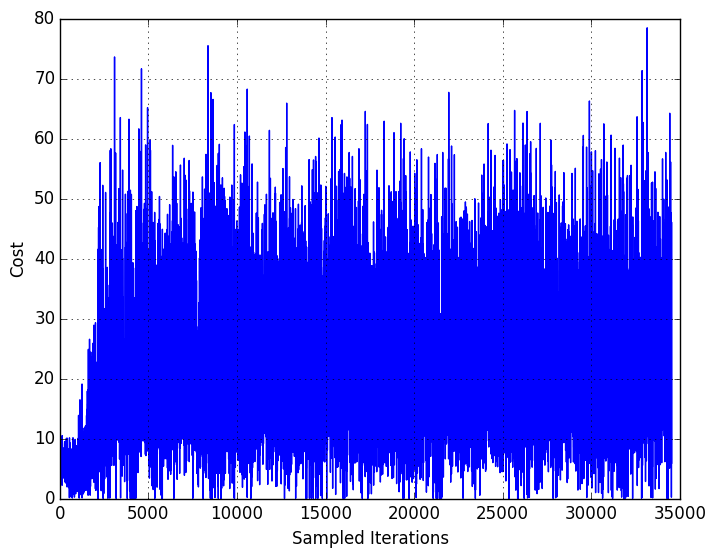

In [59]:
# plot the cost per iteration
sampleIdxJ = [1+sampleCostAtEveryItr*i for i in 0:length(J)-1]
plot(sampleIdxJ, J)
xlabel("Sampled Iterations")
ylabel("Cost")
grid("on")

In [60]:
function findAccuracy(data::Array{Tuple{AbstractString,AbstractString},1}, vocabList::Array{AbstractString,1} 
    , tagList::Array{AbstractString,1}, seqLength::Int64)
    
    correct = 0;
    ptr=1;
    p = [zeros(length(tagList)) for i in 1:seqLength];
    h = [zeros(1,hiddenLayerSize) for i in 1: seqLength]; # hidden layers (at time t)
    hPrev = zeros(1,hiddenLayerSize);
    for i in 1:length(data)/seqLength
        
        # prepare inputs (we're sweeping from left to right in steps seq_length long)
        if ptr+seqLength-1 > length(data) # whenever we are looking at the data from the start
            break # return if data is alread read
        end
        # generate sequence
        seqData = data[ptr:ptr+seqLength-1];
        x = Vector{Float64}[];
        y = Vector{Float64}[];
        for word_tag in seqData
            word = word_tag[1];
            tag = word_tag[2];
            # convert to one-hot vectors
            # words
            wordVec = zeros(length(vocabList));
            findWord = collect(vocabList.==word)
            if length(findWord[findWord.==true]) == 0
                # unknown word: UNK_W
                findWord[length(findWord)] = true;
            end
            wordVec[findWord] = 1;
            # tags
            tagVec = zeros(length(tagList));
            findTag = collect(tagList.==tag)
            if length(findTag[findTag.==true]) == 0
                # unknown tag: UNK_T
                findTag[length(findTag)] = true;
            end
            tagVec[findTag] = 1;
            # push to the sequence
            push!(x , wordVec);
            push!(y , tagVec);
        end
        # feedforward
        cost = forwardRNN(x, y, h, p, hPrev);
        hPrev = h[size(h,1)];
        
        prediction = [indmax(p[j]) for j in 1:length(seqData)];
        truth = [indmax(y[j]) for j in 1:length(seqData)];
        # accuracy
        for j in 1:length(seqData)
            if truth[j] == prediction[j]
                correct = correct + 1;
            end
        end
        ptr += seqLength; # move data pointer
    end
    accuracy = correct/length(data)*100;
    return accuracy;
end

findAccuracy (generic function with 1 method)

In [61]:
accuracy = findAccuracy(dataTrain, vocabListTrain, tagListTrain, seqLen);
println("accuracy: ", accuracy);

accuracy: 18.01048029877537


### Test data

In [49]:
# read data
vocabListTest, tagListTest, dataTest  = readWordTagData("data/pos/05-test-input.txt");
#readData("data/pos/wiki-en-test.norm");
# will use vocab list and tag list created at the training time
#accuracy, result = findAccuracy(dataTest, vocabListTrain, tagListTrain, seqLen);
println("accuracy: ", accuracy);

LoadError: LoadError: BoundsError: attempt to access 1-element Array{SubString{ASCIIString},1}:
 "a"
  at index [2]
while loading In[49], in expression starting on line 2

- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Deep Learning Lecture 12: Recurrent Neural Nets and LSTMs](https://youtu.be/56TYLaQN4N8)
- [ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION](http://arxiv.org/abs/1412.6980)
- [Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](http://jmlr.org/papers/v12/duchi11a.html)
- [NLP Programming Tutorial](http://www.phontron.com/slides/nlp-programming-en-08-rnn.pdf)
- [Lec [5.1]: Deep Learning, Recurrent neural network](https://youtu.be/AvyhbrQptHk)
